# Классификация - кошка/ не кошка(собака)

In [49]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from tqdm import tqdm
from tensorboard.backend.event_processing import event_accumulator

## Данные
Распаковка, обработка и разделение на train, test выборки с учетом классов

In [50]:
df = pd.read_csv("dataset/data.csv")
print(df.head())

         image  label
0  image_1.png      1
1  image_2.png      1
2  image_3.png      1
3  image_4.png      1
4  image_5.png      1


In [51]:
transform = transforms.ToTensor()

In [52]:
def load_image(row, img_dir="dataset/images"):
    img_path = os.path.join(img_dir, row.image)
    img = Image.open(img_path).convert("RGB")
    img = transform(img)
    y = torch.tensor(row.label, dtype=torch.long)
    return img, y

In [53]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=52, stratify=df.label)

In [54]:
train_list = [load_image(row) for _, row in train_df.iterrows()]
test_list = [load_image(row) for _, row in test_df.iterrows()]

In [55]:
train_loader = DataLoader(train_list, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list, batch_size=32, shuffle=False)

In [56]:
batch_size = 32
epochs = 30

## Модели

In [57]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(1024), nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256)
        )        
        self.classifier = nn.Sequential(
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        emb = self.features(x)
        x = self.classifier(emb)
        return emb, x

In [13]:
class TransferLearning(nn.Module):
    def __init__(self):
        super(TransferLearning, self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Sequential(            
            nn.Linear(self.backbone.fc.in_features, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.backbone(x)

## Инициализация моделей

In [58]:
cnn = CNN()

In [15]:
tl = TransferLearning()

In [59]:
device = torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn.parameters(), lr=0.01)
optimizer_tl = optim.SGD(tl.parameters(), lr=0.01)
cnn_writer = SummaryWriter(log_dir="logs/cnn")
tl_writer = SummaryWriter(log_dir="logs/tl")

## Обучение

In [60]:
def train_model(model, optimizer, writer):
    model.to(device)
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for img, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            img, y = img.to(device), y.to(device)
            optimizer.zero_grad()
            
            x = model(img)
            if isinstance(x, tuple):
                _, x = x
            elif isinstance(x, torch.Tensor):
                pass
            loss = criterion(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)        
        writer.add_scalar("Loss/train", avg_loss, epoch)
    
    writer.close()
    print(f"Training time: {time.time() - start_time:.2f} seconds")

In [61]:
train_model(cnn, optimizer_cnn, cnn_writer)

Epoch 30/30: 100%|██████████| 50/50 [01:58<00:00,  2.36s/it]

Training time: 3441.42 seconds


In [16]:
train_model(tl, optimizer_tl, tl_writer)

Epoch 30/30: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]

Training time: 269.16 seconds


#### Графики ошибок

In [62]:
event_acc = event_accumulator.EventAccumulator("logs/cnn")
event_acc.Reload()
loss_events_cnn = event_acc.Scalars("Loss/train")

In [18]:
event_acc = event_accumulator.EventAccumulator("logs/tl")
event_acc.Reload()
loss_events_tl = event_acc.Scalars("Loss/train")

In [63]:
epochs_cnn = [e.step for e in loss_events_cnn]
avg_loss_cnn = [e.value for e in loss_events_cnn]

In [20]:
epochs_tl = [e.step for e in loss_events_tl]
avg_loss_tl = [e.value for e in loss_events_tl]

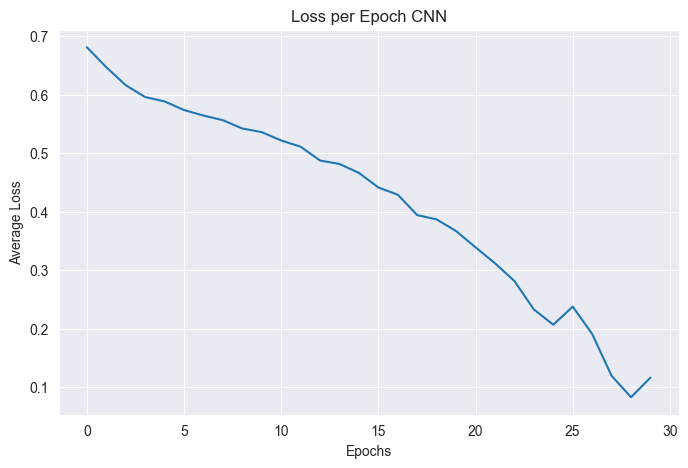

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_cnn, avg_loss_cnn, label="Avg Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss per Epoch CNN")
plt.show()

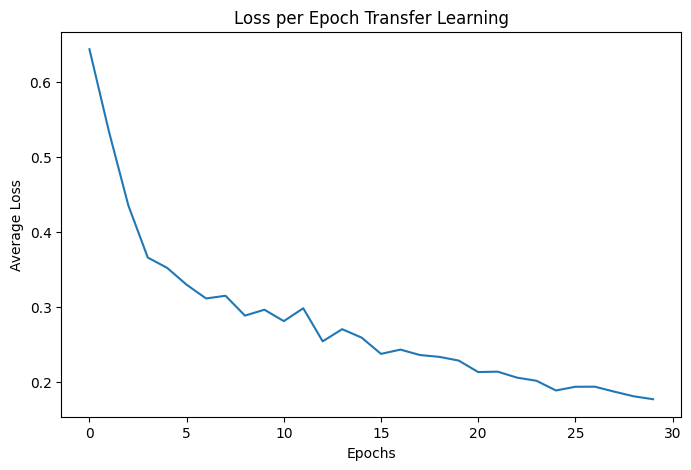

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_tl, avg_loss_tl, label="Avg Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss per Epoch Transfer Learning")
plt.show()

## Тестовая выборка

In [65]:
def evaluate_model(model):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for img, y in tqdm(test_loader, desc="Evaluating"):
            img, y = img.to(device), y.to(device)
    
            x = model(img)
            if isinstance(x, tuple):
                _, x = x
            elif isinstance(x, torch.Tensor):
                pass
            probabilities = torch.softmax(x, dim=1)[:, 1]
            _, predicted = torch.max(x, 1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='binary'),
        "Recall": recall_score(y_true, y_pred, average='binary'),
        "F1 Score": f1_score(y_true, y_pred, average='binary'),
        "ROC AUC": roc_auc_score(y_true, y_scores)
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return y_true, y_scores

In [66]:
def roc_curve_plot(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### CNN

In [67]:
y_true, y_scores = evaluate_model(cnn)

Evaluating: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]

Accuracy: 0.7950
Precision: 0.8010
Recall: 0.7850
F1 Score: 0.7929
ROC AUC: 0.8566


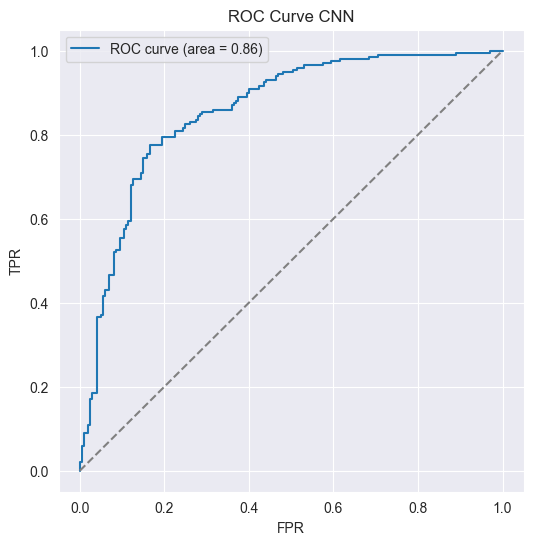

In [68]:
roc_curve_plot(y_true, y_scores, "ROC Curve CNN")

### Transfer Learning

In [27]:
y_true, y_scores = evaluate_model(tl)

Evaluating: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

Accuracy: 0.9100
Precision: 0.9141
Recall: 0.9050
F1 Score: 0.9095
ROC AUC: 0.9586


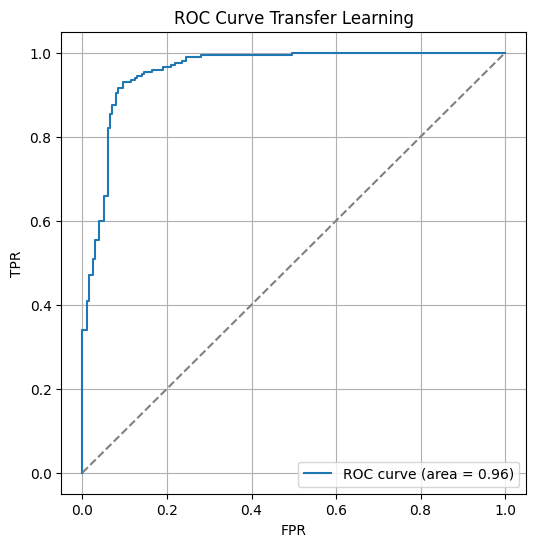

In [28]:
roc_curve_plot(y_true, y_scores, "ROC Curve Transfer Learning")

Я обучала cnn и tl на одинаковом количестве эпох, так что очевидно, что модель с переносом переобучилась. + у меня небольшой датасет с довольно похожими картинками.

## Эмбендинги

In [69]:
def extract_embeddings(model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for img, y in test_loader:
            img = img.to(device)
            emb, _ = model(img)
            
            emb = emb.view(emb.size(0), -1)
            
            embeddings.append(emb.cpu().numpy())
            labels.append(y.numpy())
            
    return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

In [70]:
embeddings, labels = extract_embeddings(cnn)

In [71]:
tsne = TSNE(n_components=2, random_state=52)
embeddings_2d = tsne.fit_transform(embeddings)

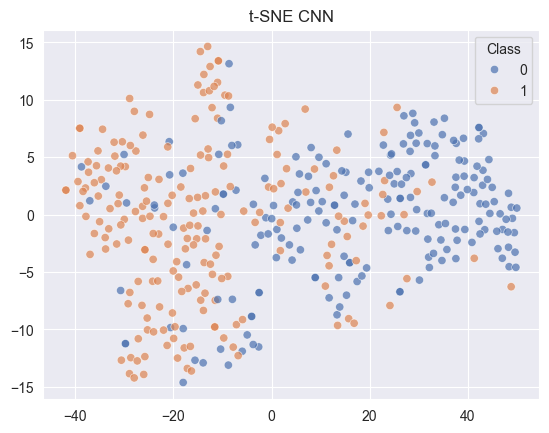

In [73]:
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette="deep", alpha=0.7)
plt.title("t-SNE CNN")
plt.legend(title="Class")
plt.show()